# Morphen: Multi-Sersic Image Fitting Decomposition for Optical Data
`morphen`, is a collection of python tools for astronomical image analysis. <br>

Author: Geferson Lucatelli <br>
email: geferson.lucatelli@postgrad.manchester.ac.uk <br>
email2: gefersonlucatelli@gmail.com<br>
Code Version: 0.3.1b <br>
Codename: Pelicoto <br>

The main goal of this tutorial is to use a combination of Sersic functions to model the brightness distribution of an astronomical image, as robust as possible and as simplified as possible. At the end, the full decomposition can be achieved simply by running two notebook cells. 

This tutorial is an adaptation of the original implementation, more focused for radio interferometric images
[`morphen/image_decomposition/morphen_sersic.ipynb`](https://github.com/lucatelli/morphen/blob/main/image_decomposition/morphen_sersic.ipynb). However, the code base is exactly the same (small differences are highlighted in the text below).

The code uses GPU acceleration when available (through `JaX`), thus fast.
The implementation is semi-automated, as in the current stage, it requires the user to specify if a detected structure is mono-component or multi-component. 

Specific details can be found here: 
[`image_decomposition/README.md`](https://github.com/lucatelli/morphen/blob/main/image_decomposition/README.md)


Multiple libraries, functions, etc, are placed in the library file: 
[`morphen/libs/libs.py`](https://github.com/lucatelli/morphen/blob/main/libs/libs.py).


The module [`morphen/morphen.py`](https://github.com/lucatelli/morphen/blob/main/morphen.py)
helps to deal with different kinds of tasks. You can run it on a notebook (or as a `CLI`, but still experimental).



#### Differences from the original implementation (radio images focused)
Development Warning: The fitting implementation for optical images is in an early testing stage. The code base is exactly the same as the one used for radio interferometric images, which is more stable. The key difference is that the PSF is a required input for optical images. 

For optical images, we require a better modelling of the PSF, a better evaluation of the background rms maps, source cleaning, finding, etc. This will be improved in the near future. 



#### Version issues of dependencies:

Please, do not use `LMFIT` version above 1.1.0, use specifically 1.1.0 (`pip install lmfit==1.1.0`).
We are investigating non-convergence issues with the latest versions of `LMFIT`.

See [`morphen/install_instructions.md`](https://github.com/lucatelli/morphen/blob/main/install_instructions.md) for installation details.


## Importing required libraries

In this tutorial, we are going to import the file `morphen/morphen.py` as a module, and import the library file `morphen/libs/libs.py`. 


All python functions are located in the file `libs.py`, and `morphen.py` is a wrapper
to simplify all required analysis. 

We are also going to use all the imports made within those files,
so we avoid conflicts with the imports made in this notebook.


In [1]:
import sys
sys.path.append('../libs/')
sys.path.append('../')
import morphen as mp
import libs as mlibs
import numpy as np

def reload_libs():
    """
    If edits to the libraries are made, this function will reload them.
    """
    import libs as mlibs
    from importlib import reload
    reload(mlibs)
    import morphen as mp
    reload(mp)


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

# Reading the Data: IMAGE 2D and PSF 2D

In [10]:
psf_root_path = '../../data_examples_dev/optical/efigi/'
root_path = '../../data_examples_dev/optical/efigi/lenticulars/barred/showcase/'
imagename = root_path + 'PGC0049408_r_seg.fits' #use this for the showcase
psf_name = psf_root_path+'psf_efigi_s13.fits'

In [16]:
#using the built-in function to read the data
input_data=mp.read_data(filename=imagename,
                        psfname=psf_name)

++>> Image File: PGC0049408_r_seg.fits
-->> No Residual File was provided.
++>> PSF File: psf_efigi_s13.fits


We can plot these images. I am going to use the help function called `mlibs.eimshow`.

<Axes: xlabel='Offset [px]', ylabel='Offset [px]'>

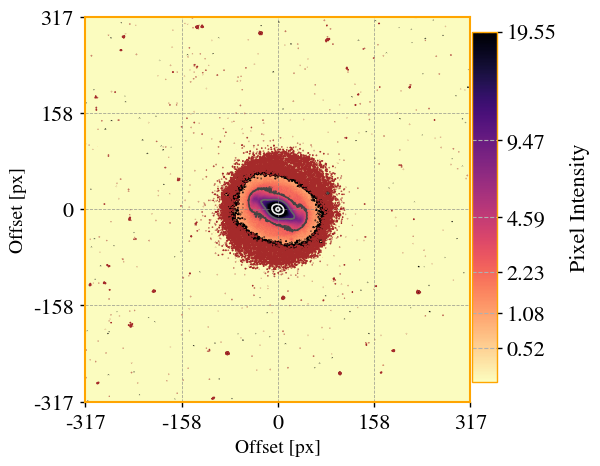

In [18]:
mlibs.eimshow(input_data.filename,crop=False,
              vmax_factor=0.1,
              with_wcs=True,
              vmin_factor=2,
              box_size=200,flux_units='any',
              projection='px')

# Source Extraction and Model Constraints
Now, it is time to prepare ourselves for the image fitting. 

Before we head to the Sérsic fitting, we should inspect the structure of the emission. 
For that, we can perform a simple source extraction from the image and compute basic prior information, which includes:

1. Finding relevant regions of emission, and applying deblending where required. We will have the locations `(x0,y0)` of these regions.
2. Then, we compute first order sizes and effective intensities of these regions, for example $R_{50}$, $I_{50}$ and, additionally the Petrosian radius $R_{\rm p}$.
3. It is also relevant to quantify the axis ratio $q=b/a$ and position angles $PA$ of these structures. 

We use this prior information to construct a physically constrained Sérsic model. 

Note however that, necessarily, we do not require accurate shape properties from these individual regions. We are looking for initial physical constraints for our model, and those quantities will be optimised during minimisation.

To do this, we use the class `mp.source_extraction`, which allow us to find relevant regions of emission and determine our prior information. Only after that, one should proceed to the Sérsic fitting. 


### Testing the Source-Extraction
The source extraction uses the `SEP` or the `PetroFit` packages (`photutils`). `SEP` is a python implementation of the SExtractor algorithm (Bertin & Arnouts 1996), see (https://sep.readthedocs.io/en/v1.1.x/). To select which one one wants to use, use the argument `algorithm='SEP'` or `algorithm='PF'` in the class `mp.source_extraction`.


You will need to play with the parameters below until you are happy with the detection. 
Parameters that are critical for the source detection/extractions are summarised below:
```
- bwf : int
    Box width fraction in terms of the beam size
    for the background estimation.
- bhf : int
    Box height fraction in terms of the beam size
    for the background estimation.
- fwf : int
    Filter width fraction in terms of the beam size
    for the background estimation.
- fhf : int
    Filter height fraction in terms of the beam size
    for the background estimation.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- clean_param : float (unique to SEP)
    Cleaning parameter for the source extraction.
    Default is 1.0.
- deblend_cont : float (this is contrast in Photutils)
    Minimum contrast ratio used for object deblending. Default is 0.005.
    
```

WARNING: This is implementation is in an early stage, so it is not completely automated. It is required that the user interacts with it in order to check if the source detection is feasible. That usually involves, from the default parameters below, run the source extraction in the image and check if it went well. If not (e.g. false detections, artefacts, etc), play around with the parameters until good detection is satisfied. 

Lets now run a source extraction in our image to extract relevant information. 


In [19]:
"""
bwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-2
deblend_nthresh = 3
sigma_mask = 60
sigma = 50
ell_size_factor = 20
"""

'\nbwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!\nfwf, fhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!\nclean_param = 0.5\ndeblend_cont = 1e-2\ndeblend_nthresh = 3\nsigma_mask = 60\nsigma = 50\nell_size_factor = 20\n'

In [20]:
#this is a set of parameters that may work OKAY
bwf, bhf = 2, 2 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 2, 2 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-2
deblend_nthresh = 64
sigma_mask = 6
sigma = 10
ell_size_factor = 1
minarea_factor = 5

### Check Source Detection/Extraction Results with a 'dry run'.
To check if the source detection is good, you may pass the argument `dry_run=True` in the `mp.source_extraction` class, which will only display the regions detected, without performing any photometric calculations. 

This is useful in case you do not know for sure the noise structure of the image. Suppose that the number of structures detected are many (false detections, due to poor SNR or artefacts). That will take some time to compute their properties, which is not necessary. 

Note also that we specify `obs_type = 'other'`, since using this method on images other than radio interferometric images is still experimental.

+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 63 63 )
    fw,fh=( 31 31 )
+++++++++++++++++++++++
++==>> INFO: Total number of Sources/Structures (deblended) =  1


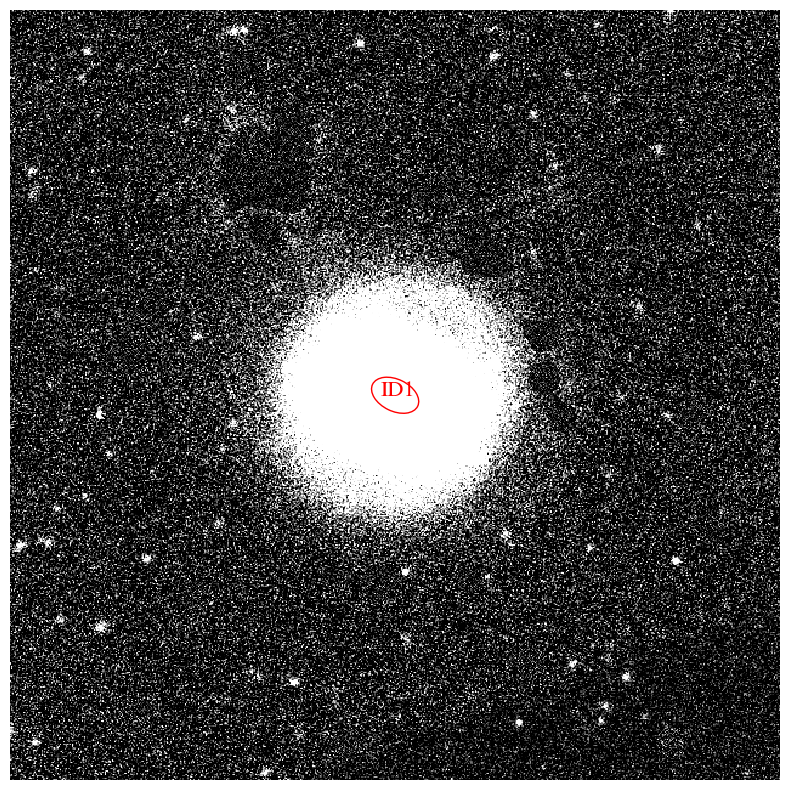

In [21]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=3,
                          show_petro_plots=True,algorithm='SEP',
                          dry_run=True, obs_type = 'other')
# plt.imshow(input_data.image_data_2D)

#### Mono-component or Multi-component structures: when using multiple Sersic functions
Another very important part is related to the structure of the emission. We need to specify if a detected region is mono-component or multi-component (e.g. a blob or a bulge+disk and additional features). This is done by passing the argument `ids_to_add` in the `mp.source_extraction` class. This is a list to specify which detected region 
requires more than one component to be fitted to the data. Think this as a bulge+disk decomposition. 
The whole emission will be detected as a single region, but it is clear that we need to model it as two components (bulge+disk).
In our example above, we have only one structure, `ID1`. But, by inspection of the data, we see that our lenticular galaxy is more complex than that. We see the bulge, a circumnuclear structure and a more extended disk in the outer edges. 

In this example, one would set `ids_to_add=['1','2']` to indicate that the region `ID1` needs two extra components to be fitted.Lets review this by each case. 

- When `ids_to_add=['1']` is set, it means that a new component will be added to the region `ID1`, so now 
`COMP_1` and `COMP_2`. The initial size parameters (and boundaries) will be larger than the initial size parameters of `COMP_1` (currently, the factor is 3).
- When `ids_to_add=['1','2']` is set, it means that one component will be added to the region `ID1` 
and another component will be indexed to the newly created `COMP_2`. This will impose that the initial size parameters of `COMP_3` is larger than `COMP_2` (and also `COMP_1`), i.e. `COMP_1 < COMP_2 < COMP_3`. 
- We can also specify `ids_to_add=['1','1']`, so two components will be added to the region `ID1`, 
but both (`COMP_2` and `COMP_3`) will have similar initial size parameters, i.e. `COMP_1 < COMP_2 = COMP_3`.

This is the manual part of the Sersic fitting within `morphen`. If you are happy with the results, you can set `dry_run=False` and photometry will be performed in the data. 

***We are working in a strategy to automate this process in future releases.***



Input image is not a string.
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 63 63 )
    fw,fh=( 31 31 )
+++++++++++++++++++++++
++==>> INFO: Total number of Sources/Structures (deblended) =  1


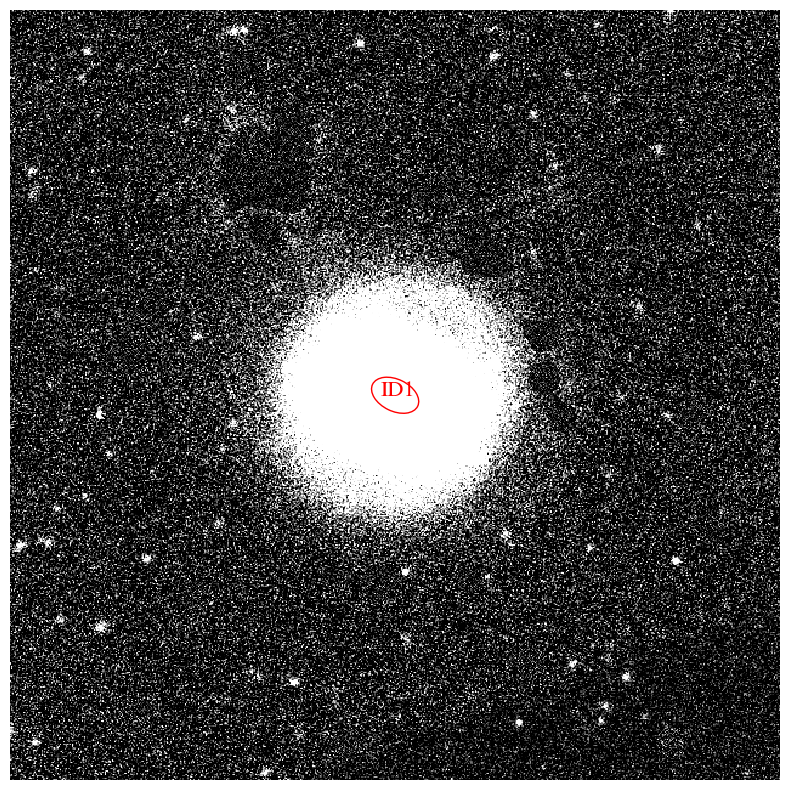

# of structures (IDs) to be fitted = 1
# of model components (COMPS) to be fitted = 3


In [79]:
SE = mp.source_extraction(input_data, ids_to_add=['1','2'],
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf=bwf, bhf=bhf, fwf=fwf, fhf=fhf,
                          clean_param=clean_param, 
                          deblend_cont=deblend_cont, minarea_factor=minarea_factor,
                          deblend_nthresh=deblend_nthresh,
                          apply_mask=False,sigma_mask=sigma_mask,
                          show_petro_plots=False,obs_type = 'other',algorithm='SEP',
                          dry_run=False)

In [80]:
SE.sources_photometries

{'c1_PA': -25.98810260041613,
 'c1_q': 0.6681616106230205,
 'c1_area': 849.0,
 'c1_Re': 16.439132987175398,
 'c1_x0c': 316.5520564017391,
 'c1_y0c': 316.3297397363569,
 'c1_label': 1,
 'c1_R50': 9.668533706741348,
 'c1_R20': 4.6009201840368075,
 'c1_R80': 15.58231646329266,
 'c1_C1': 0.529787320980654,
 'c1_Snu': 2903.8341216938124,
 'c1_Rp': 20.749749949989997,
 'c1_Rpidx': 41,
 'c1_rlast': 48,
 'c1_I50': 3.1378072670527866,
 'ncomps': 3,
 'c2_PA': -25.98810260041613,
 'c2_q': 0.6681616106230205,
 'c2_area': 849.0,
 'c2_Re': 16.439132987175398,
 'c2_x0c': 316.5520564017391,
 'c2_y0c': 316.3297397363569,
 'c2_label': 1,
 'c2_R50': 29.005601120224043,
 'c2_R20': 4.6009201840368075,
 'c2_R80': 15.58231646329266,
 'c2_C1': 0.529787320980654,
 'c2_Snu': 2903.8341216938124,
 'c2_Rp': 20.749749949989997,
 'c2_Rpidx': 41,
 'c2_rlast': 48,
 'c2_I50': 0.3137807267052787,
 'c3_PA': -25.98810260041613,
 'c3_q': 0.6681616106230205,
 'c3_area': 849.0,
 'c3_Re': 16.439132987175398,
 'c3_x0c': 316.55

In [81]:
for i in range(1,SE.sources_photometries['ncomps']+1):
    print(f"Initial conditions for (R50, I50) COMP_{i} = ({SE.sources_photometries['c'+str(i)+'_R50']:.2f},{SE.sources_photometries['c'+str(i)+'_I50']:.4f})")


Initial conditions for (R50, I50) COMP_1 = (9.67,3.1378)
Initial conditions for (R50, I50) COMP_2 = (29.01,0.3138)
Initial conditions for (R50, I50) COMP_3 = (87.02,0.0314)


In the dictionary `SE.sources_photometries`, we have now basic properties of each component of the image:
- `x0 `  : x-coordinate centre position
- `y0 `  : y-coordinate centre position
- `q  `  : axis ratio
- `PA `  : position angle
- `Snu`  : total flux (sum of pixels)
- `Re `  : effective circular area radii 
- `Rp `  : Petrosian Radius
- `R50 ` : half-light radius
- `I50 ` : effective intensity (I at R50)

These parameters will be used to feed the initial hints for the Sersic Decomposition

### Background estimations
For better fitting results, a background map bay be provided to the fitting routine. Here, we just compute a basic background map.

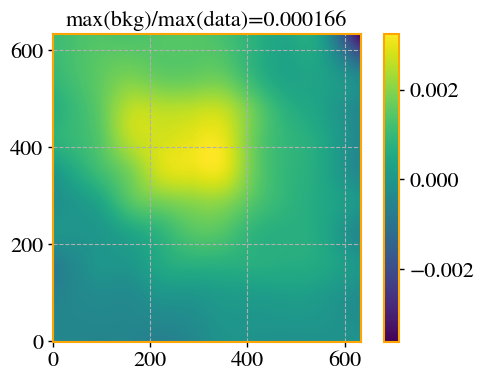

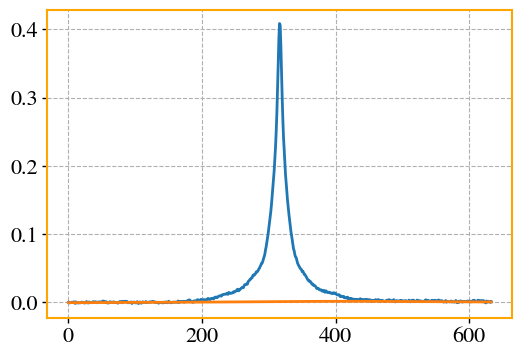

In [82]:
sep_bkg = mlibs.sep_background(input_data.filename,show_map=True,
                               bw=64, 
                               bh=64, 
                               fw=int(7), 
                               fh=int(7))
mlibs.plt.figure()
mlibs.plt.plot(np.mean(input_data.image_data_2D,axis=1))
mlibs.plt.plot(np.mean(sep_bkg.back(),axis=1))
# mlibs.plt.semilogy()
# mlibs.plt.ylim(-1e-5,1e-4)

We should not provide this map for the minimisation, since it is a convolved map. 
We can randomise this map, os it will preserve the amplitude of the original background map. 
Randomising is done via `mlibs.shuffle_2D`.

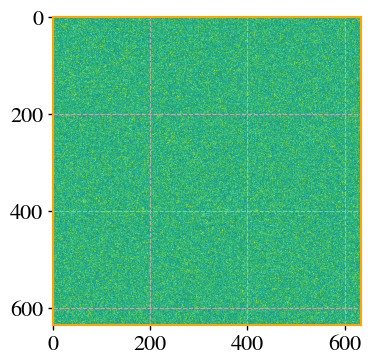

In [83]:
mlibs.plt.imshow(mlibs.shuffle_2D(sep_bkg.back()))

In [84]:
# _, mask_for_fit = mlibs.mask_dilation(input_data.filename, 
#                               dilation_type='disk',
#                               rms = input_data.rms_res,
#                               sigma=6, #number of sigma above the rms value
#                               iterations=1, 
#                               dilation_size=None,
#                               PLOT=True)

In [85]:
SE.sources_photometries

{'c1_PA': -25.98810260041613,
 'c1_q': 0.6681616106230205,
 'c1_area': 849.0,
 'c1_Re': 16.439132987175398,
 'c1_x0c': 316.5520564017391,
 'c1_y0c': 316.3297397363569,
 'c1_label': 1,
 'c1_R50': 9.668533706741348,
 'c1_R20': 4.6009201840368075,
 'c1_R80': 15.58231646329266,
 'c1_C1': 0.529787320980654,
 'c1_Snu': 2903.8341216938124,
 'c1_Rp': 20.749749949989997,
 'c1_Rpidx': 41,
 'c1_rlast': 48,
 'c1_I50': 3.1378072670527866,
 'ncomps': 3,
 'c2_PA': -25.98810260041613,
 'c2_q': 0.6681616106230205,
 'c2_area': 849.0,
 'c2_Re': 16.439132987175398,
 'c2_x0c': 316.5520564017391,
 'c2_y0c': 316.3297397363569,
 'c2_label': 1,
 'c2_R50': 29.005601120224043,
 'c2_R20': 4.6009201840368075,
 'c2_R80': 15.58231646329266,
 'c2_C1': 0.529787320980654,
 'c2_Snu': 2903.8341216938124,
 'c2_Rp': 20.749749949989997,
 'c2_Rpidx': 41,
 'c2_rlast': 48,
 'c2_I50': 0.3137807267052787,
 'c3_PA': -25.98810260041613,
 'c3_q': 0.6681616106230205,
 'c3_area': 849.0,
 'c3_Re': 16.439132987175398,
 'c3_x0c': 316.55

## Multi-Sersic Decomposition
Now, we are ready to perform the multi-Sersic decomposition. Our example will fit 3 model components. 
We use the source extraction object `SE` to feed it into the multi-Sersic fitting, called by the class `mp.sersic_multifit_general`.


#### Relevant arguments:

##### Fixed Sersic indeces:
```
    fix_n : list (same shape as the number of components)
        List of booleans to fix the Sersic index.
        Default is None, will attibute True to all elements.
    fix_value_n : list (same shape as the number of components)
        List of values to fix the Sersic index.
        Default is None, will attribute 0.5 to all elements. 
```
Fix or not the Sersic indeces of each component (`fix_n`) and to which value it should be fixed (`fix_value_n`). 
By default, the keeps free all Sersic indeces for all model components. If an element of this list is `fix_n = [True]`, a value can be set using `fix_value_n = [1.0]`, for example. The size of the list must be the same as the number of components (`SE.sources_photometries['ncomps']`). If you are performing bulge-disk decomposition, these two list will look like `fix_n = [False,True]` and `fix_value_n = [None,1.0]`. 

##### Fixed positions:

```
    dr_fix : list (same shape as the number of components)
        List of values to fix radially (dr) the positions x0,y0. 
        This will be the max boundary for each direction x and y.
        Default is None, will attribute 10 to all elements.

```

It also fixes all components to its detected positions `(x0,y0)` during the source extraction step (check `SE.sources_photometries['c{i}_x0c']` and  `SE.sources_photometries['c{i}_y0c']`), but gives a search interval of +/-10 px during the optimisation. 

You can modify these options by passing the arguments `dr_fix = [3,50]`, meaning that `COMP_1` is very spatially constrained to its detection location, and can vary only +/- 3 pixels, while `COMP_2` (our additional component for structure `ID1`) is spatially constrained to a larger bound, the algorithm will search in the boundary of +/- 50 pixels during optimisation relative to the detection coordinates.

##### Fix geometrical grid:

```
    fix_geometry : list bool, optional
        If True, then the geometry of the components will be fixed to elliptical geometry
        The default is [True,].
```
From [(Peng et al., 2002)]('https://ui.adsabs.harvard.edu/abs/2002AJ....124..266P/abstract'), the geometry of the model grid (`np.meshgrid`) can be changed with the boxiness parameter `C`. The default in `morphen` is to use `True` for all model components (as `False` is showing signs of instabilities). Setting true, will set the parameter `C` to `0.0`; setting false, will allow `C` to range from `-2` to `2`.

##### Labeling compact and diffuse components.

Another important observation is that, since we want to decompose the structure in terms of compact and diffuse emission, we must specify which model components corresponds to smaller spherical structures (bulges) and disk-like  structures. In our case, we may want to label `COMP_1` as our spherical model, and `COMP_2` as our diffuse/disk model. The argument `comp_ids` is used for that. 

```
    comp_ids : list
        List of integers or strings that indicates which components are compact.
        Default is ['1'], will label `COMP_1` as compact.
```
In our example, we use `comp_ids=['1']`. Do not worry about the labels of extended components, the algorithm will determine automatically by exclusion (in our case, will be `2`). If your model had a single model component (e.g. in the previous step, you have used `ids_to_add = []`), diffuse structures will be considered to be the residual only. 

Note that specifying this or not, will not affect the fit, it will just display preliminary results/plots after the fit is completed.
By default, the code assumes `comp_ids=['1']` in all occasions.




2024-03-26 11:03:14 - DEBUG - ---------------------------------------
2024-03-26 11:03:14 - DEBUG -  <<< PERFORMING CONVOLUTION WITH JAX >>> 
2024-03-26 11:03:14 - DEBUG - ---------------------------------------
2024-03-26 11:03:14 - DEBUG -  ==> Using provided RMS map. 



                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

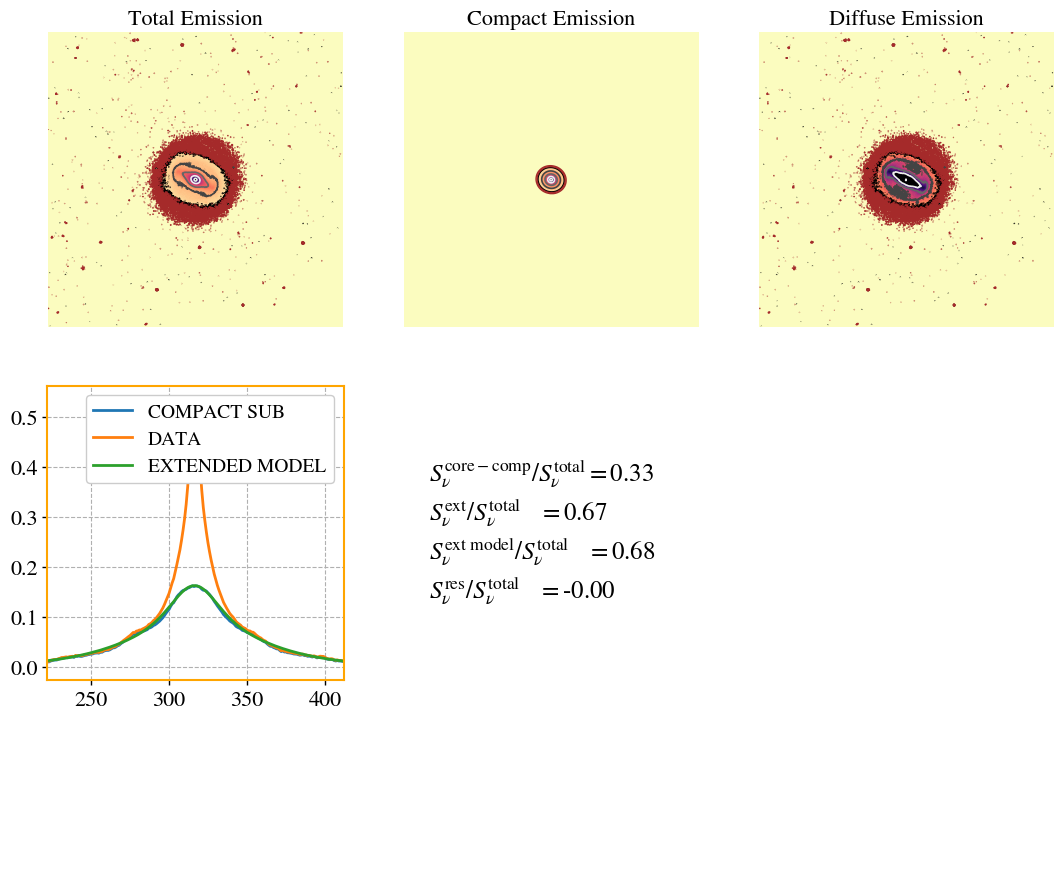

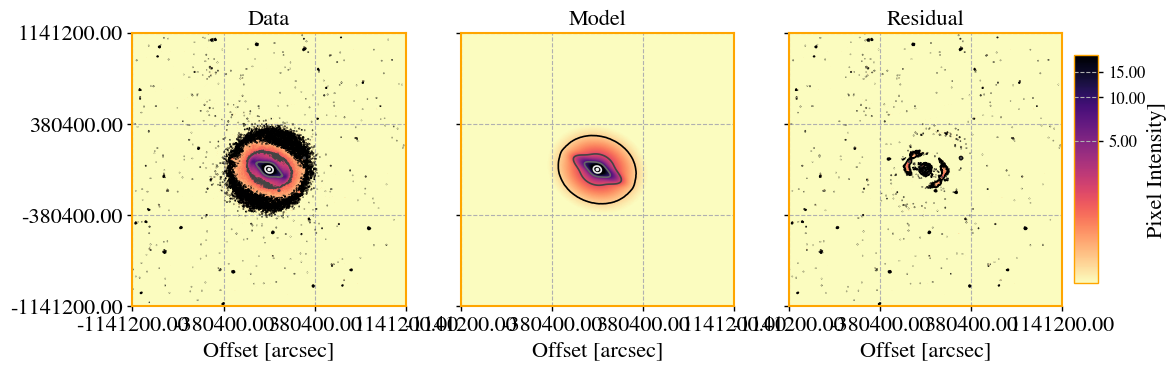

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:11715: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.xlim(0, plotlim * cell_size)


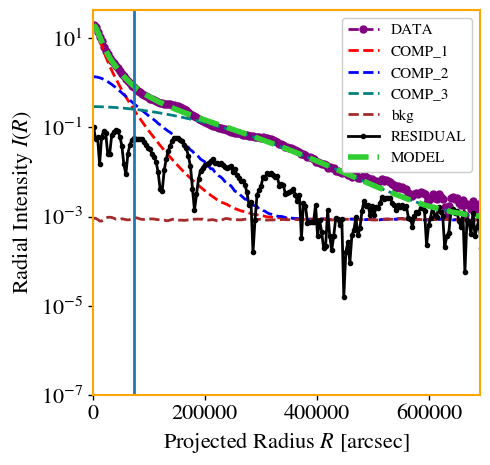

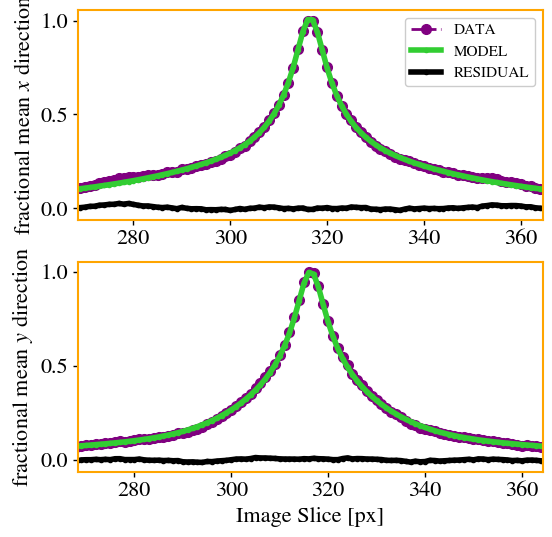

In [101]:
reload_libs()
smfg = mp.sersic_multifit_general(input_data,
                                SE, #source extraction object, from previous step
                                convolution_mode='GPU',
                                # self_bkg=True,
                                which_residual = 'user',
                                # which_residual = None,
                                bkg_rms_map = mlibs.shuffle_2D(sep_bkg.back()),
                                tr_solver='exact', #'lsmr or exact'
                                fix_geometry=[True,True,True,True], #for stability purposes, keep True for now. 
                                comp_ids=['1'],# which component label is compact/bulge?
                                dr_fix=[5,5,300,300],#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=[None,0.3,None,None],#for each component, the Sersic index value to be fixed. 
                                fix_n=[False,False,False,False],#for each component, fix or not the Sersic index. 
                                z = 0.1 #just an arbitrary value for now.
                                )

## Analysing Results

All results are stored in the object `smfg`. 

### Fitting parameters results
By default, the minimisation will be run twice. This is a strategy used by `LMFIT` that helps on the convergence of parameters. The results from the first run can be obtained from `smfr.result_1` and the parameters from the final run from `smfr.result_mini`.

In [102]:
smfg.result_mini.params

Parameters([('f1_x0', <Parameter 'f1_x0', value=316.2321301969332 +/- 0.00101, bounds=[306.5520564017391:326.5520564017391]>), ('f1_y0', <Parameter 'f1_y0', value=316.1305397555886 +/- 0.000987, bounds=[306.3297397363569:326.3297397363569]>), ('f1_PA', <Parameter 'f1_PA', value=-16.142772458936925 +/- 0.189, bounds=[-115.98810260041613:64.01189739958387]>), ('f1_ell', <Parameter 'f1_ell', value=0.08335002391743887 +/- 0.000736, bounds=[0.06636767787539591:0.75]>), ('f1_n', <Parameter 'f1_n', value=1.6952279324278523 +/- 0.00521, bounds=[0.3:8.0]>), ('f1_In', <Parameter 'f1_In', value=2.6647438223563404 +/- 0.0218, bounds=[0.6275614534105574:313.78072670527865]>), ('f1_Rn', <Parameter 'f1_Rn', value=8.106497513522136 +/- 0.0667, bounds=[1.9337067413482698:14.502800560112021]>), ('f1_cg', <Parameter 'f1_cg', value=0.009999999900000008 +/- 0.00411, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=316.39159352720384 +/- 0.021, bounds=[306.5520564017391:326.5520564017391]>), ('f2_y0', <Parameter 'f2_y0', value=316.0369939963542 +/- 0.0119, bounds=[306.3297397363569:326.3297397363569]>), ('f2_PA', <Parameter 'f2_PA', value=-26.580943139679825 +/- 0.0217, bounds=[-115.98810260041613:64.01189739958387]>), ('f2_ell', <Parameter 'f2_ell', value=0.7159057963821825 +/- 0.000904, bounds=[0.06636767787539591:0.75]>), ('f2_n', <Parameter 'f2_n', value=0.5010644906164288 +/- 0.0031, bounds=[0.3:8.0]>), ('f2_In', <Parameter 'f2_In', value=0.7103442848503501 +/- 0.00531, bounds=[0.06275614534105574:31.378072670527867]>), ('f2_Rn', <Parameter 'f2_Rn', value=29.308401606518977 +/- 0.671, bounds=[5.8011202240448085:43.508401680336064]>), ('f2_cg', <Parameter 'f2_cg', value=-0.009999998889205136 +/- 0.011, bounds=[-0.01:0.01]>), ('f3_x0', <Parameter 'f3_x0', value=315.81765571277083 +/- 0.0636, bounds=[306.5520564017391:326.5520564017391]>), ('f3_y0', <Parameter 'f3_y0', value=315.7393039983175 +/- 0.0525, bounds=[306.3297397363569:326.3297397363569]>), ('f3_PA', <Parameter 'f3_PA', value=-20.32620392676468 +/- 0.28, bounds=[-115.98810260041613:64.01189739958387]>), ('f3_ell', <Parameter 'f3_ell', value=0.1607121249761698 +/- 0.00161, bounds=[0.06636767787539591:0.75]>), ('f3_n', <Parameter 'f3_n', value=0.5570856675232695 +/- 0.00435, bounds=[0.3:8.0]>), ('f3_In', <Parameter 'f3_In', value=0.13294835565349752 +/- 0.000958, bounds=[0.0062756145341055745:3.137807267052787]>), ('f3_Rn', <Parameter 'f3_Rn', value=60.09470017313917 +/- 1.53, bounds=[17.403360672134426:130.52520504100818]>), ('f3_cg', <Parameter 'f3_cg', value=0.009999999900000023 +/- 0.0109, bounds=[-0.01:0.01]>), ('s_a', <Parameter 's_a', value=1.0099999998990001 +/- 0.036, bounds=[0.99:1.01]>)])

#### Parameter uncertainties
Parameter uncertainties are obtained from the covariance matrix of the fit. Uncertainties are only available when using the 
`least_squares` method (default in `morphen`). Such parameters can be accessed via `smfg.result_mini.params[param_name].stderr`.

In [103]:
smfg.result_mini.params['f1_Rn'].stderr, \
    smfg.result_mini.params['f1_n'].stderr, \
        smfg.result_mini.params['f1_In'].stderr

(0.06670098325490152, 0.00520888274702551, 0.021769778005167686)

### Generated files
Model images (convolved and deconvolved) are saved as `.fits` files having a copy of the header 
from the original image file data. Example of these files are: 
 - `*_dec_model.fits` >> Deconvolved total model image.
 - `*_conv_model.fits` >> Convolved total model image.
 - `*_residual.fits` >> Residual model image. 
 - `*_dec_model_component_i.fits` >> Deconvolved model image for model component `i`. `i` vary from 1 to the total number of model components.
 - `*_model_component_i.fits` >> Convolved model image for model component `i`.
 - `*_compact.fits` >> Convolved model image containing all compact structures.
 - `*_dec_compact.fits` >> Deconvolved model image containing all compact structures.
 - `*_ext_model.fits.fits` >> Convolved model image containing all extended structures.
 - `*_dec_ext_model.fits.fits` >> Deconvolved model image containing all extended structures.
 - `*_extended.fits` >> Convolved image containing the extended structures. This is obtained by `extended = data - conv_compact`.
 - `*_fit.pickle` >> Contains a pickle object with all the `LMFIT` results.
 - `*_fit_modeldict.pickle` >> Contains a pickle object with all model components images (convolved and deconvolved). Note, this is a large file, and probably will be removed in a future version.
 - `*_model_mini_params.csv` >> contain the best-fit minimised parameters and (when possible) standard errors.
 - `*_mini_corr.csv` >> When successful, this contains the correlation matrix for the model parameters. 

All files are overwritten if the fitting function is called again.

## The structure of the diffuse emission
Lets visualise the model images of our fitting. The 2D model images are stored in `smfg.model_dict`. 
Deconvolved model components are labelled as `smfg.model_dict['model_ci']` and convolved model components 
as `smfg.model_dict['model_ci_conv']`. 

In [104]:
# smfg.model_dict

  >> Center -->  [316 316]


Text(0.5, 1.0, 'Data')

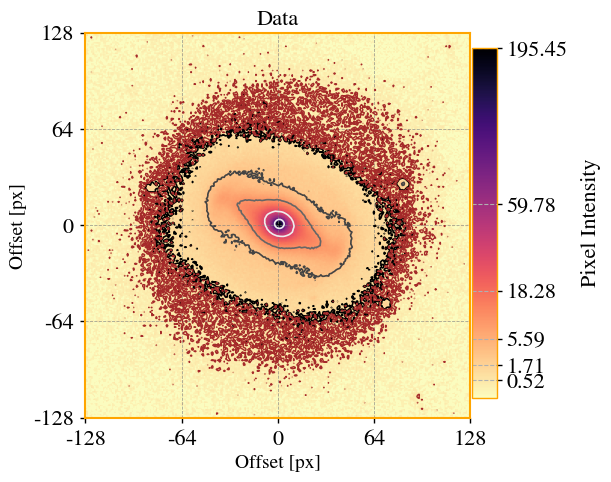

In [105]:
# center = nd.maximum_position(input_data.image_data_2D)
center = (int(smfg.result_mini.params['f1_x0'].value),int(smfg.result_mini.params['f1_y0'].value))
rms = mlibs.mad_std(mlibs.ctn(input_data.filename))
ax = mlibs.eimshow(input_data.filename,
                   projection='px',vmin_factor=0.10,
                   crop=True,box_size=128,
                   vmax_factor=0.1,flux_units='any',
             vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Data')

Text(0.5, 1.0, 'Diffuse Emission')

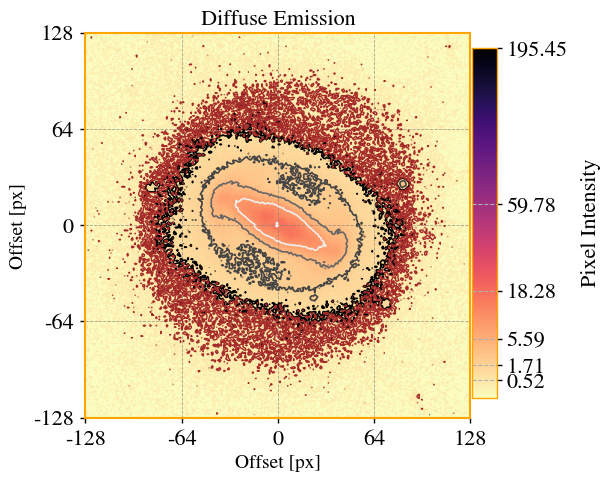

In [106]:
ax = mlibs.eimshow(input_data.image_data_2D-\
                   smfg.model_dict['model_c1_conv'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.1,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Diffuse Emission')

Text(0.5, 1.0, 'Compact Deconvolved')

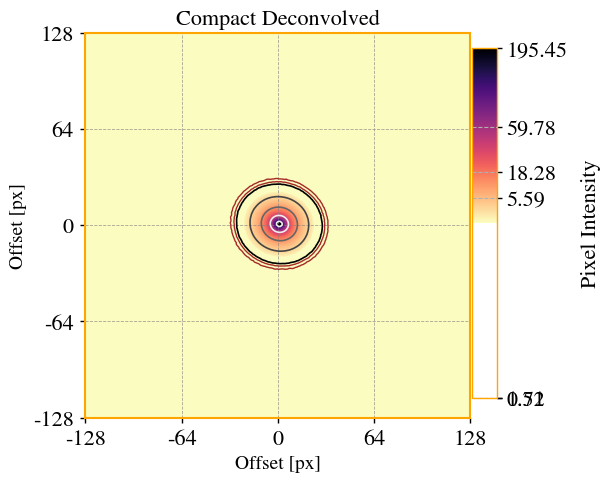

In [107]:
ax=mlibs.eimshow(smfg.model_dict['model_c1'],
                   projection='px',vmin_factor=10.0,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Compact Convolved')

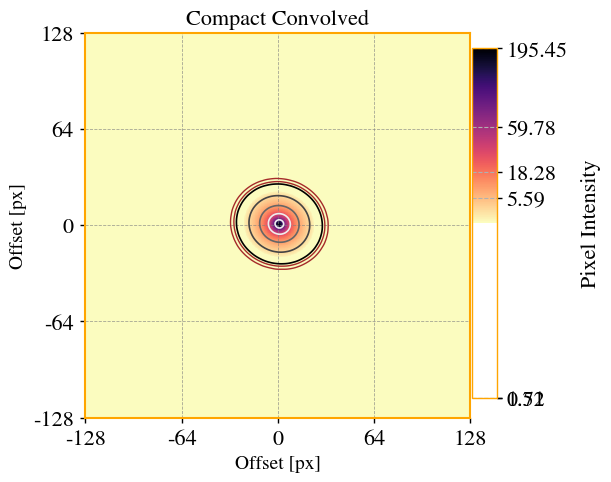

In [108]:
ax=mlibs.eimshow(smfg.model_dict['model_c1_conv'],
                   projection='px',vmin_factor=10.0,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Compact Convolved')

In [109]:
# ax=mlibs.eimshow(smfr.model_dict['model_c2'],
#                    projection='px',vmin_factor=0.10,center=center,
#                    crop=True,box_size=80,vmax_factor=0.09,flux_units='any',
#                    vmax=input_data.image_data_2D.max(),
#                    rms=rms)
# ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Model Deconvolved')

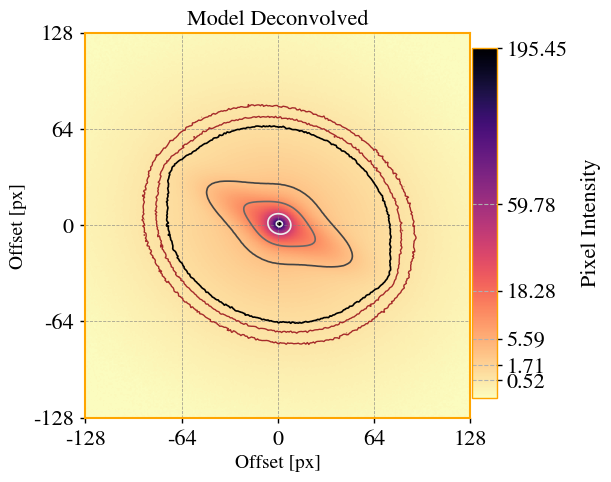

In [110]:
ax=mlibs.eimshow(smfg.model_dict['model_total_dec'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Model Deconvolved')

Text(0.5, 1.0, 'Model Convolved')

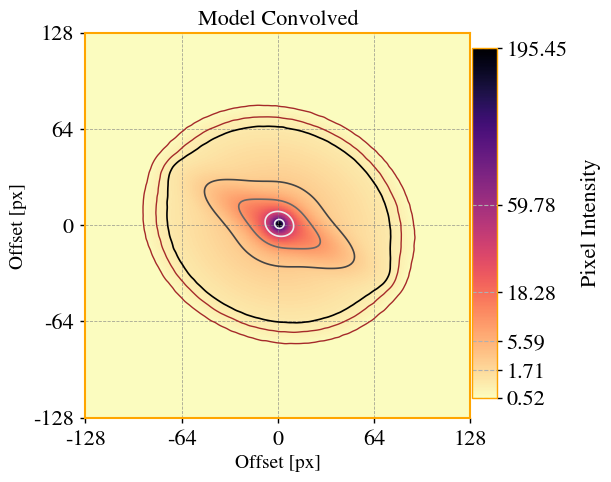

In [111]:
ax=mlibs.eimshow(smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=3.0,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Model Convolved')

Text(0.5, 1.0, 'Residual')

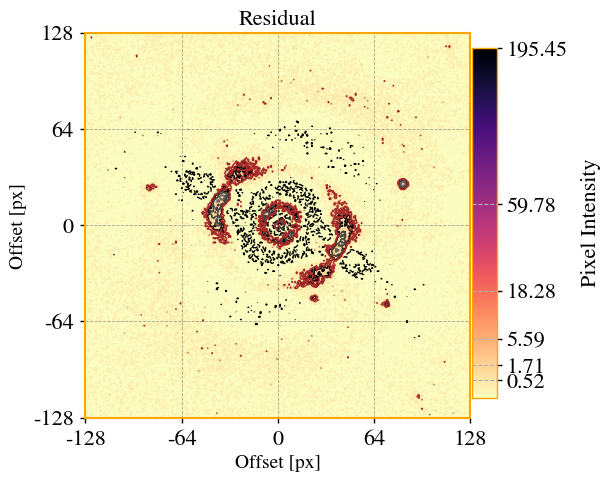

In [112]:
ax = mlibs.eimshow(input_data.image_data_2D- smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=0.10,center=center,
                   crop=True,box_size=128,
                   vmax_factor=0.09,flux_units='any',
                   vmax=input_data.image_data_2D.max(),
                   rms=rms)
ax.set_title('Residual')

Text(0.5, 1.0, 'Residual (no vmax)')

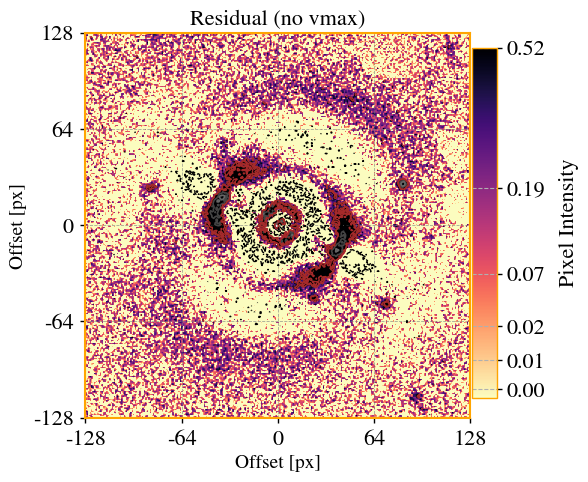

In [113]:
ax = mlibs.eimshow(input_data.image_data_2D- smfg.model_dict['model_total_conv'],
                   projection='px',vmin_factor=3.0,center=center,
                   crop=True,box_size=128,
                   vmax_factor=1.0,flux_units='any',
                   vmax=np.mean(input_data.image_data_2D- smfg.model_dict['model_total_conv']),
                   rms=rms)
ax.set_title('Residual (no vmax)')

In [117]:
print(f"Total flux density in model = {smfg.results_fit['flux_density_model']:.2f} [pixel sum]")
print(f"Total flux density in data = {smfg.results_fit['flux_data']:.2f} [pixel sum]")
print(f"Total flux density in residual = {smfg.results_fit['flux_density_res']:.2f} [pixel sum]")


Total flux density in model = 7310.63 [pixel sum]
Total flux density in data = 7280.19 [pixel sum]
Total flux density in residual = -30.44 [pixel sum]


#### Decomposition results
Lets check the estimated fluxes from the bulge, the bar and the disk


In [120]:
print(f"Total flux in compact (bulge) = {smfg.results_fit['flux_density_compact']:.2f} [pixel sum]")
print(f"Total flux in extended model (bar+disk) = {smfg.results_fit['flux_density_extended_model']:.2f} [pixel sum]")

# The total flux density in the diffuse regions are saved in:
print(f"Total flux in extended (bar+disk) = {smfg.results_fit['flux_density_ext']:.2f} [pixel sum]")
print(f"Total flux residual = {smfg.results_fit['flux_density_res']:.2f} [pixel sum]")


Total flux in compact (bulge) = 2369.33 [pixel sum]
Total flux in extended model (bar+disk) = 4941.30 [pixel sum]
Total flux in extended (bar+disk) = 4880.67 [pixel sum]
Total flux residual = -30.44 [pixel sum]


##### Bulge to total 


In [122]:
print(f" Bulge to total = {(smfg.results_fit['flux_density_compact']/smfg.results_fit['flux_density_ext']):.2f}")

 Bulge to total = 0.49


***MORE INFO WILL BE ADDED HERE AS DEVELOPMENT PROGRESS***